In [33]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt
from sklift.models import (
    ClassTransformation,
    TwoModels,
   
)
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklift.metrics import uplift_at_k, qini_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklift.metrics import qini_curve

In [2]:
enriched_final_rfm_df=pd.read_parquet('../csv_export/RFM.parquet')

In [3]:
enriched_final_rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223393 entries, 0 to 223392
Data columns (total 30 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   CUSTOMER_ID                     223393 non-null  object 
 1   Recency                         223393 non-null  int64  
 2   Frequency                       223393 non-null  int64  
 3   Monetary                        223393 non-null  float64
 4   Total_Units                     223393 non-null  int64  
 5   Total_Organic_Discount          223393 non-null  float64
 6   Total_Extra_Discount            223393 non-null  float64
 7   Total_Discounts                 223393 non-null  float64
 8   AVG_ORGANIC_DISCOUNT_PER_ORDER  223393 non-null  float64
 9   USED_ORGANIC_DISCOUNT_RATIO     223393 non-null  float64
 10  AVG_EXTRA_DISCOUNT_PER_ORDER    223393 non-null  float64
 11  USED_EXTRA_DISCOUNT_RATIO       223393 non-null  float64
 12  AVG_TOTAL_DISCOU

In [4]:
enriched_final_rfm_df.dropna(inplace=True)

## Churn Label

In [5]:


categorical_cols = [
    'FAVOURITE_STORE',
    'FAVOURITE_STORE_TYPE',
    'FAVOURITE_PAYMENT_METHOD',
    'FAVORITE_CATEGORY',
    'FAVORITE_SUB_CATEGORY',
    'FAVORITE_WEEKDAY'
]

numerical_cols = [
    col for col in enriched_final_rfm_df.select_dtypes(include=['int64', 'float64']).columns
    if col != 'CUSTOMER_ID' and col != 'FAVORITE_HOUR'  
]

categorical_cols.append('FAVORITE_HOUR')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

X_processed = preprocessor.fit_transform(enriched_final_rfm_df)

num_features = numerical_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_features = list(num_features) + list(cat_features)

X_df = pd.DataFrame(X_processed, columns=all_features, index=enriched_final_rfm_df.index)


## IsolationForest

In [6]:


iso_forest = IsolationForest(contamination=0.05, random_state=42)  
enriched_final_rfm_df['Anomaly_Score'] = iso_forest.fit_predict(X_df)

enriched_final_rfm_df['Churn_Label_IsoForest'] = (enriched_final_rfm_df['Anomaly_Score'] == -1).astype(int)


## LocalOutlierFactor


In [12]:


lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
enriched_final_rfm_df['LOF_Score'] = lof.fit_predict(X_df)

enriched_final_rfm_df['Churn_Label_LOF'] = (enriched_final_rfm_df['LOF_Score'] == -1).astype(int)


## OneClassSVM

In [19]:


oc_svm = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')  
oc_svm.fit(X_df)

labels_ocsvm = oc_svm.predict(X_df)  
enriched_final_rfm_df['Churn_Label_OCSVM'] = (labels_ocsvm == -1).astype(int)


## Treatment


In [13]:
enriched_final_rfm_df['Treatment'] = (enriched_final_rfm_df['USED_EXTRA_DISCOUNT_RATIO'] > 0.05).astype(bool)


## Modelling 

In [40]:

models = {
    "TwoModels_XGB_vs_RF": TwoModels(
        estimator_trmnt=XGBClassifier(n_estimators=1000, learning_rate=0.05, max_depth=6, eval_metric='logloss', random_state=42),
        estimator_ctrl=RandomForestClassifier(n_estimators=1000, random_state=42),
        method='vanilla'
    ),
      'tm_logreg_svm': TwoModels(
        estimator_trmnt=LogisticRegression(max_iter=1000),
        estimator_ctrl=SVC(probability=True),
        method='vanilla'
    ),
      'ct_xgb': ClassTransformation(
        estimator=XGBClassifier( eval_metric='logloss')
    ),
    'ct_rf': ClassTransformation(
        estimator=RandomForestClassifier(n_estimators=1000, random_state=42),
    ),

    
}


## Evaluation 

## IsoForest

In [41]:
yLabel_IsoForest = enriched_final_rfm_df.loc[X_df.index, 'Churn_Label_IsoForest']
treatment = enriched_final_rfm_df.loc[X_df.index, 'Treatment'].astype(int)



X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
    X_df, yLabel_IsoForest, treatment, test_size=0.3, stratify=treatment, random_state=42
)


In [42]:

results = {}
best_score = -1
best_model = None

for name, model in models.items():
    print(f"\nTraining {name}...")
    if name == "UpliftRandomForest":
        model.fit(X_train, y_train, treatment=treat_train)
        preds = model.predict(X_test)
    else:
        model.fit(X_train, y_train, treat_train)
        preds = model.predict(X_test)
    
    qini_score = qini_auc_score(y_test, preds, treat_test)
    results[name] = {
        "uplift": preds,
        "qini_auc": qini_score
    }
    print(f"{name} Qini AUC: {qini_score:.4f}")
    if qini_score > best_score:
        best_score = qini_score
        best_model = model



Training TwoModels_XGB_vs_RF...
TwoModels_XGB_vs_RF Qini AUC: 0.5479

Training tm_logreg_svm...
tm_logreg_svm Qini AUC: 0.4575

Training ct_xgb...
ct_xgb Qini AUC: 0.3598

Training ct_rf...
ct_rf Qini AUC: 0.3461


## OCSVM

In [43]:
yLabel_OCSVM = enriched_final_rfm_df.loc[X_df.index, 'Churn_Label_OCSVM']
treatment = enriched_final_rfm_df.loc[X_df.index, 'Treatment'].astype(int)


X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
    X_df, yLabel_OCSVM, treatment, test_size=0.3, stratify=treatment, random_state=42
)

In [44]:
results = {}
best_score = -1
best_model = None

for name, model in models.items():
    print(f"\nTraining {name}...")
    if name == "UpliftRandomForest":
        model.fit(X_train, y_train, treatment=treat_train)
        preds = model.predict(X_test)
    else:
        model.fit(X_train, y_train, treat_train)
        preds = model.predict(X_test)
    
    qini_score = qini_auc_score(y_test, preds, treat_test)
    results[name] = {
        "uplift": preds,
        "qini_auc": qini_score
    }
    print(f"{name} Qini AUC: {qini_score:.4f}")
    if qini_score > best_score:
        best_score = qini_score
        best_model = model



Training TwoModels_XGB_vs_RF...
TwoModels_XGB_vs_RF Qini AUC: 0.6018

Training tm_logreg_svm...
tm_logreg_svm Qini AUC: 0.1761

Training ct_xgb...
ct_xgb Qini AUC: 0.4571

Training ct_rf...
ct_rf Qini AUC: 0.3520


## LOF

In [45]:
yLabel_LOF = enriched_final_rfm_df.loc[X_df.index, 'Churn_Label_LOF']
treatment = enriched_final_rfm_df.loc[X_df.index, 'Treatment'].astype(int)



X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
    X_df, yLabel_LOF, treatment, test_size=0.3, stratify=treatment, random_state=42
)



In [46]:
results = {}
best_score = -1
best_model = None

for name, model in models.items():
    print(f"\nTraining {name}...")
    if name == "UpliftRandomForest":
        model.fit(X_train, y_train, treatment=treat_train)
        preds = model.predict(X_test)
    else:
        model.fit(X_train, y_train, treat_train)
        preds = model.predict(X_test)
    
    qini_score = qini_auc_score(y_test, preds, treat_test)
    results[name] = {
        "uplift": preds,
        "qini_auc": qini_score
    }
    print(f"{name} Qini AUC: {qini_score:.4f}")
    if qini_score > best_score:
        best_score = qini_score
        best_model = model



Training TwoModels_XGB_vs_RF...
TwoModels_XGB_vs_RF Qini AUC: 0.4405

Training tm_logreg_svm...
tm_logreg_svm Qini AUC: -0.2838

Training ct_xgb...
ct_xgb Qini AUC: 0.2001

Training ct_rf...
ct_rf Qini AUC: 0.2410


## Qini Curve

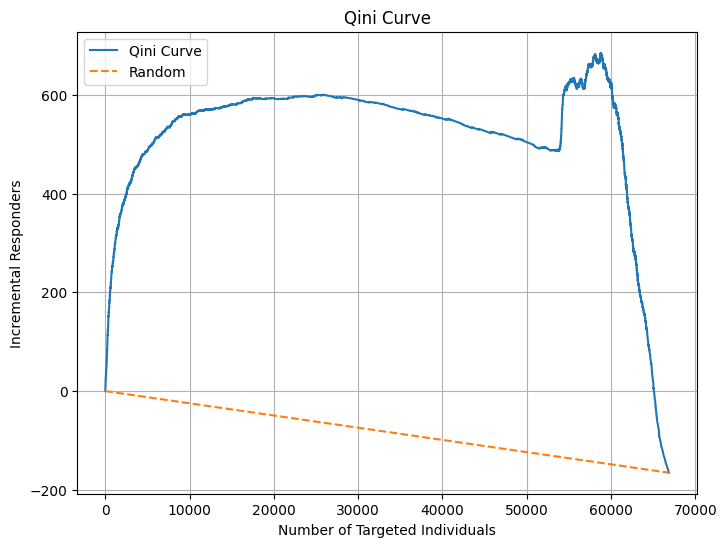

In [ ]:
uplift_scores = best_model.predict(X_test)
x_qini, y_qini = qini_curve(y_true=y_test, uplift=uplift_scores, treatment=treat_test)


plt.figure(figsize=(8, 6))
plt.plot(x_qini, y_qini, label='Qini Curve')
plt.plot([0, x_qini[-1]], [0, y_qini[-1]], '--', label='Random')  
plt.xlabel('Number of Targeted Individuals')
plt.ylabel('Incremental Responders')
plt.title('Qini Curve')
plt.legend()
plt.grid(True)
plt.show()


## Targets Dataset

In [24]:
enriched_final_rfm_df.loc[X_test.index, 'Uplift_Score'] = best_model.predict(X_test)


In [25]:
churned_customers = enriched_final_rfm_df[enriched_final_rfm_df['Churn_Label_OCSVM'] == 1]

top_churned_customers = churned_customers.sort_values('Uplift_Score', ascending=False).head(10000)


In [28]:
def assign_discount(uplift):
    if uplift > 0.5:        
        return 0.25
    elif uplift > 0.3:      
        return 0.15
    elif uplift > 0.15:     
        return 0.05
    else:
        return 0.00          


In [29]:
top_churned_customers['Assigned_Discount'] = top_churned_customers['Uplift_Score'].apply(assign_discount)
top_churned_customers['Expected_Revenue_Saved'] = top_churned_customers['Monetary'] * top_churned_customers['Uplift_Score']
top_churned_customers['Discount_Cost'] = top_churned_customers['Monetary'] * top_churned_customers['Assigned_Discount']
top_churned_customers['ROI'] = top_churned_customers['Expected_Revenue_Saved'] / top_churned_customers['Discount_Cost'].replace(0, 1)


In [30]:
top_targets = top_churned_customers.sort_values(by='Uplift_Score', ascending=False).head(10000)


In [31]:
top_targets

,CUSTOMER_ID,Recency,Frequency,Monetary,Total_Units,Total_Organic_Discount,Total_Extra_Discount,Total_Discounts,AVG_ORGANIC_DISCOUNT_PER_ORDER,USED_ORGANIC_DISCOUNT_RATIO,...,Churn_Label_IsoForest,Treatment,LOF_Score,Churn_Label_LOF,Churn_Label_OCSVM,Uplift_Score,Assigned_Discount,Expected_Revenue_Saved,Discount_Cost,ROI
45705,34d981afb6646e7b832ce90113798b69ec0e16b60784b9...,502,1,27.5000,1,7.20,0.0000,7.2000,7.200000,1.00000,...,0,False,1,0,1,0.956316,0.25,26.298677,6.87500,3.825262
30081,22ebb56cc52adb05d8130d12dad9ef8f75c9ccdf97a52c...,142,1,47.6782,1,7.51,0.0118,7.5218,7.510000,1.00000,...,0,True,-1,1,1,0.951540,0.25,45.367713,11.91955,3.806160
74107,551561bbcd61010315d7dfa565cffc7ff666ebf8626a91...,156,1,54.6882,1,6.49,0.0118,6.5018,6.490000,1.00000,...,0,True,1,0,1,0.943970,0.25,51.624029,13.67205,3.775881
36765,2a929c8db43150d44af9e4666de2d5180e3cf47b405e29...,99,1,47.7882,1,7.50,0.0118,7.5118,7.500000,1.00000,...,0,True,1,0,1,0.941290,0.25,44.982537,11.94705,3.765159
126231,903afffa75d18516799cbd38d6b470eee395b371026350...,187,1,37.5782,1,7.31,0.0118,7.3218,7.310000,1.00000,...,0,True,1,0,1,0.932445,0.25,35.039591,9.39455,3.729779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188848,d7f9a82423984e75e664167491af16c26ecd221a44a4ea...,229,3,352.2000,3,132.00,0.0000,132.0000,44.000000,1.00000,...,0,False,1,0,1,NaN,0.00,NaN,0.00000,NaN
188887,d806c0e92d7d7985628855d4548f1c04c3395966474376...,547,61,2796.0100,91,46.00,646.3900,692.3900,0.754098,0.04918,...,0,True,1,0,1,NaN,0.00,NaN,0.00000,NaN
188954,d81a959edfb697abd10df381f8bf34e3a45ef131ad16ef...,11,96,13262.6900,182,2000.95,0.3000,2001.2500,20.843229,1.00000,...,0,False,1,0,1,NaN,0.00,NaN,0.00000,NaN
188973,d81f5d45c27704b06d87026d147abe319d3cd65159f76f...,18,124,8829.2312,219,1134.72,856.6188,1991.3388,9.150968,0.75000,...,1,True,1,0,1,NaN,0.00,NaN,0.00000,NaN
